# Import the libraries

In [32]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color_pal = sns.color_palette()
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, accuracy_score
plt.style.use('fivethirtyeight')
import yfinance as yf

# 1. Classification Task - Apple Shares

Here, we would like to predict the direction of closing price movement, whether it goes up or down. In this case, XGBClassifier should be a good fit.

## 1.1 Data import, feature creation

In [33]:
aapl = yf.Ticker('AAPL').history(period='5y').drop(['Dividends', 'Stock Splits', 'Open', 'High', 'Low', 'Volume'], axis=1)

In [34]:
aapl.head()

,Close
Date,
2018-12-12 00:00:00-05:00,40.576008
2018-12-13 00:00:00-05:00,41.019924
2018-12-14 00:00:00-05:00,39.707375
2018-12-17 00:00:00-05:00,39.337845
2018-12-18 00:00:00-05:00,39.848942


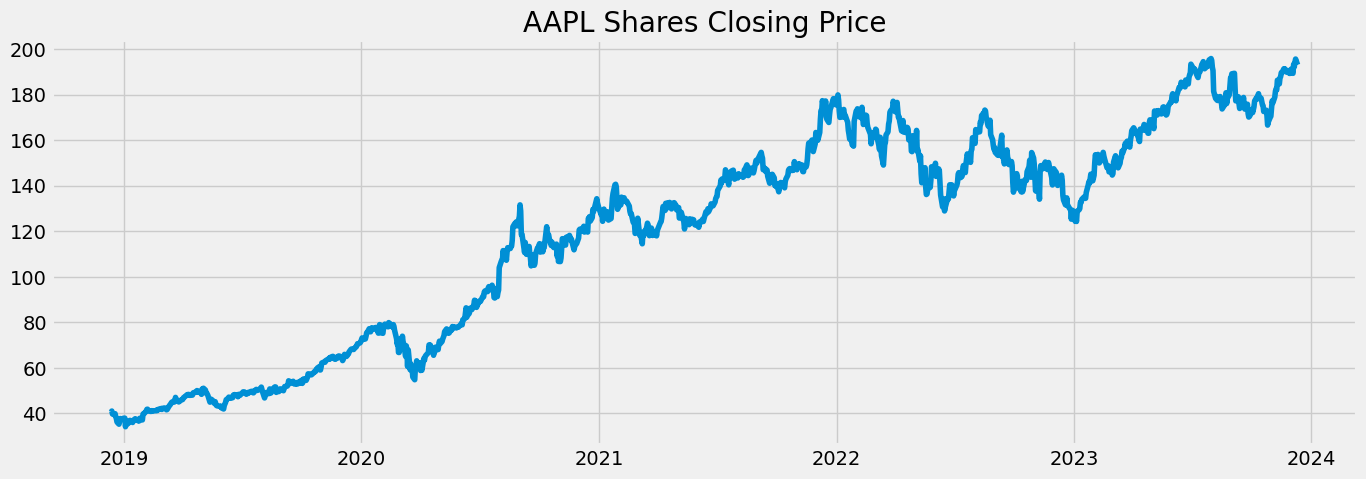

In [35]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(aapl['Close'], linestyle='-')

ax.set_title('AAPL Shares Closing Price')

plt.show()

What we use here is log returns - we calculate log returns for each date, and create columns for log returns values for 5 days before that date.

In [36]:
aapl['Returns'] = np.log(aapl / aapl.shift(1)).dropna()

In [37]:
for lag in range(0,5):
    aapl[f'Returns-{lag+1}'] = aapl['Returns'].shift(lag+1)
aapl = aapl.dropna()

In [38]:
aapl

,Close,Returns,Returns-1,Returns-2,Returns-3,Returns-4,Returns-5
Date,,,,,,,
2018-12-20 00:00:00-05:00,37.631783,-0.025559,-0.031688,0.012909,-0.009350,-0.032521,0.010881
2018-12-21 00:00:00-05:00,36.168068,-0.039672,-0.025559,-0.031688,0.012909,-0.009350,-0.032521
2018-12-24 00:00:00-05:00,35.232258,-0.026215,-0.039672,-0.025559,-0.031688,0.012909,-0.009350
2018-12-26 00:00:00-05:00,37.713371,0.068053,-0.026215,-0.039672,-0.025559,-0.031688,0.012909
2018-12-27 00:00:00-05:00,37.468613,-0.006511,0.068053,-0.026215,-0.039672,-0.025559,-0.031688
...,...,...,...,...,...,...,...
2023-12-05 00:00:00-05:00,193.419998,0.020844,-0.009510,0.006768,0.003058,-0.005424,0.003209
2023-12-06 00:00:00-05:00,192.320007,-0.005703,0.020844,-0.009510,0.006768,0.003058,-0.005424
2023-12-07 00:00:00-05:00,194.270004,0.010088,-0.005703,0.020844,-0.009510,0.006768,0.003058


We convert the values of log returns to 1 or 0 - we would like to forecast the direction of stock price movement.

In [39]:
aapl_dir = aapl.copy(deep=True)
for col in aapl.columns[1:]:
    aapl_dir[col] = [1 if i > 0 else 0 for i in aapl[col]]

In [40]:
aapl_dir

,Close,Returns,Returns-1,Returns-2,Returns-3,Returns-4,Returns-5
Date,,,,,,,
2018-12-20 00:00:00-05:00,37.631783,0,0,1,0,0,1
2018-12-21 00:00:00-05:00,36.168068,0,0,0,1,0,0
2018-12-24 00:00:00-05:00,35.232258,0,0,0,0,1,0
2018-12-26 00:00:00-05:00,37.713371,1,0,0,0,0,1
2018-12-27 00:00:00-05:00,37.468613,0,1,0,0,0,0
...,...,...,...,...,...,...,...
2023-12-05 00:00:00-05:00,193.419998,1,0,1,1,0,1
2023-12-06 00:00:00-05:00,192.320007,0,1,0,1,1,0
2023-12-07 00:00:00-05:00,194.270004,1,0,1,0,1,1


## 1.2 Train/Test Split

Our test set - Apple returns after 1st of January 2022. We train the model on the direction of returns before that date.

In [41]:
train_aapl = aapl_dir.loc[aapl.index < '01-01-2022'].copy()
test_aapl = aapl_dir.loc[aapl.index >= '01-01-2022'].copy()

In [42]:
FEATURES = ['Returns-1', 'Returns-2', 'Returns-3', 'Returns-4', 'Returns-5']
TARGET = ['Returns']

In [43]:
X_train_aapl = train_aapl[FEATURES].copy()
y_train_aapl = train_aapl[TARGET].copy()

X_test_aapl = test_aapl[FEATURES].copy()
y_test_aapl = test_aapl[TARGET].copy()

## 1.3 XGBoost Model 

In [44]:
class1 = xgb.XGBClassifier(n_estimators=100, learning_rate=0.5)

In [45]:
class1.fit(X_train_aapl, y_train_aapl, eval_set=[(X_train_aapl, y_train_aapl), (X_test_aapl, y_test_aapl)], verbose=True)

[0]	validation_0-logloss:0.67192	validation_1-logloss:0.70018
[1]	validation_0-logloss:0.66630	validation_1-logloss:0.70884
[2]	validation_0-logloss:0.66424	validation_1-logloss:0.71613
[3]	validation_0-logloss:0.66347	validation_1-logloss:0.72148
[4]	validation_0-logloss:0.66308	validation_1-logloss:0.72559
[5]	validation_0-logloss:0.66292	validation_1-logloss:0.72844
[6]	validation_0-logloss:0.66285	validation_1-logloss:0.73039
[7]	validation_0-logloss:0.66280	validation_1-logloss:0.73105
[8]	validation_0-logloss:0.66275	validation_1-logloss:0.73151
[9]	validation_0-logloss:0.66272	validation_1-logloss:0.73246
[10]	validation_0-logloss:0.66269	validation_1-logloss:0.73192
[11]	validation_0-logloss:0.66266	validation_1-logloss:0.73237
[12]	validation_0-logloss:0.66264	validation_1-logloss:0.73312
[13]	validation_0-logloss:0.66261	validation_1-logloss:0.73315
[14]	validation_0-logloss:0.66259	validation_1-logloss:0.73268
[15]	validation_0-logloss:0.66257	validation_1-logloss:0.73347
[1

[42]	validation_0-logloss:0.66229	validation_1-logloss:0.73783
[43]	validation_0-logloss:0.66228	validation_1-logloss:0.73791
[44]	validation_0-logloss:0.66228	validation_1-logloss:0.73776
[45]	validation_0-logloss:0.66227	validation_1-logloss:0.73820
[46]	validation_0-logloss:0.66227	validation_1-logloss:0.73831
[47]	validation_0-logloss:0.66226	validation_1-logloss:0.73818
[48]	validation_0-logloss:0.66226	validation_1-logloss:0.73860
[49]	validation_0-logloss:0.66226	validation_1-logloss:0.73871
[50]	validation_0-logloss:0.66225	validation_1-logloss:0.73880
[51]	validation_0-logloss:0.66225	validation_1-logloss:0.73869
[52]	validation_0-logloss:0.66224	validation_1-logloss:0.73910
[53]	validation_0-logloss:0.66224	validation_1-logloss:0.73923
[54]	validation_0-logloss:0.66224	validation_1-logloss:0.73930
[55]	validation_0-logloss:0.66223	validation_1-logloss:0.73918
[56]	validation_0-logloss:0.66223	validation_1-logloss:0.73956
[57]	validation_0-logloss:0.66223	validation_1-logloss:

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## 1.4 Results

In [46]:
test_aapl['Returns_pred'] = class1.predict(X_test_aapl)

In [47]:
test_aapl[['Returns', 'Returns_pred']]

,Returns,Returns_pred
Date,,
2022-01-03 00:00:00-05:00,1,1
2022-01-04 00:00:00-05:00,0,1
2022-01-05 00:00:00-05:00,0,1
2022-01-06 00:00:00-05:00,0,1
2022-01-07 00:00:00-05:00,1,1
...,...,...
2023-12-05 00:00:00-05:00,1,0
2023-12-06 00:00:00-05:00,0,1
2023-12-07 00:00:00-05:00,1,1


The accuracy score for the prediction is:

In [48]:
accuracy_score(test_aapl['Returns'], test_aapl['Returns_pred'])

0.5122950819672131

This result is not uncommon for stock market forecasting, as it is challenging to accurately predict stock market returns (Vijh et al., 2020). The performance of the predictive model can be improved, for example, by adding new features or performing further hyperparameter tuning.

# 2. Regression Task - Bitcoin/USD Price

In the second example, we will attempt to predict the continuous values of Bitcoin price. The features we are using are previous 5 closing prices.

## 2.1 Data import, feature creation

In [49]:
btc = yf.Ticker('BTC-USD').history(period='5y').drop(['Dividends', 'Stock Splits', 'Open', 'High', 'Low', 'Volume'], axis=1)

In [50]:
btc.head()

,Close
Date,
2018-12-12 00:00:00+00:00,3486.950195
2018-12-13 00:00:00+00:00,3313.677246
2018-12-14 00:00:00+00:00,3242.484863
2018-12-15 00:00:00+00:00,3236.761719
2018-12-16 00:00:00+00:00,3252.839111


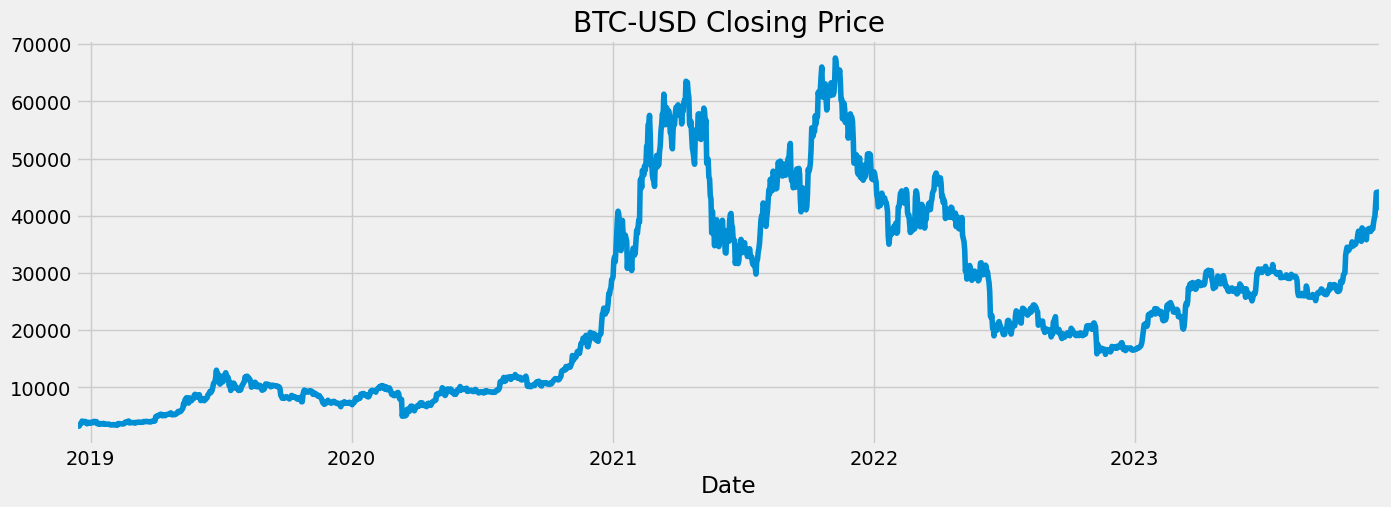

In [51]:
btc['Close'].plot(style='-', figsize=(15,5), color=color_pal[0],
        title='BTC-USD Closing Price')
plt.show()

XGBoost with decision trees as base learners cannot extrapolate (Gong et al.,2022). However, if we take a look at the graph, we can see that the Bitcoin Closing Price has reached its peak closer to the end of 2021, while the lowest price in the observable timeframe is in the beginning of 2019. As we consider our test set to be the prices from 01.01.2022, where both the maximum and minimum prices are, respectively, not above nor below the maximum and minimum prices of the 5-year period, using XGBoost with with decision trees as base learners should not be a problem.

In [52]:
for lag in range(0,5):
    btc[f'Close-{lag+1}'] = btc['Close'].shift(lag+1)
btc = btc.dropna()

In [53]:
btc.head()

,Close,Close-1,Close-2,Close-3,Close-4,Close-5
Date,,,,,,
2018-12-17 00:00:00+00:00,3545.864746,3252.839111,3236.761719,3242.484863,3313.677246,3486.950195
2018-12-18 00:00:00+00:00,3696.059082,3545.864746,3252.839111,3236.761719,3242.484863,3313.677246
2018-12-19 00:00:00+00:00,3745.950684,3696.059082,3545.864746,3252.839111,3236.761719,3242.484863
2018-12-20 00:00:00+00:00,4134.441406,3745.950684,3696.059082,3545.864746,3252.839111,3236.761719
2018-12-21 00:00:00+00:00,3896.543701,4134.441406,3745.950684,3696.059082,3545.864746,3252.839111


# 2.2 Train/Test Split

In [54]:
FEATURES = ['Close-1', 'Close-2', 'Close-3', 'Close-4', 'Close-5']
TARGET = ['Close']

As in previous case - test set is the data from 1st of January 2022, while training set is the data before that date.

In [55]:
train_btc = btc.loc[btc.index < '01-01-2022'].copy()
test_btc = btc.loc[btc.index >= '01-01-2022'].copy()

In [56]:
X_train_btc = train_btc[FEATURES].copy()
y_train_btc = train_btc[TARGET].copy()

X_test_btc = test_btc[FEATURES].copy()
y_test_btc = test_btc[TARGET].copy()

## 2.3 XGBoost Model

In [57]:
reg1 = xgb.XGBRegressor(n_estimators=200, early_stopping_rounds=50, learning_rate=0.1)
reg1.fit(X_train_btc, y_train_btc, eval_set=[(X_train_btc, y_train_btc), (X_test_btc, y_test_btc)], verbose=True)

[0]	validation_0-rmse:17246.36868	validation_1-rmse:9300.61222
[1]	validation_0-rmse:15553.66153	validation_1-rmse:8340.61347
[2]	validation_0-rmse:14030.45500	validation_1-rmse:7500.45157
[3]	validation_0-rmse:12657.69476	validation_1-rmse:6729.29105
[4]	validation_0-rmse:11422.30128	validation_1-rmse:6052.32538
[5]	validation_0-rmse:10309.86004	validation_1-rmse:5424.63385
[6]	validation_0-rmse:9306.53080	validation_1-rmse:4903.79827
[7]	validation_0-rmse:8404.02925	validation_1-rmse:4394.15391
[8]	validation_0-rmse:7591.87130	validation_1-rmse:3958.56060
[9]	validation_0-rmse:6862.16835	validation_1-rmse:3569.15284
[10]	validation_0-rmse:6204.58853	validation_1-rmse:3219.44604
[11]	validation_0-rmse:5613.10775	validation_1-rmse:2941.88965
[12]	validation_0-rmse:5081.72572	validation_1-rmse:2695.34626
[13]	validation_0-rmse:4603.72506	validation_1-rmse:2480.67728
[14]	validation_0-rmse:4174.61351	validation_1-rmse:2288.38726
[15]	validation_0-rmse:3790.23385	validation_1-rmse:2131.11

[36]	validation_0-rmse:901.83545	validation_1-rmse:1608.34769
[37]	validation_0-rmse:873.49524	validation_1-rmse:1610.00477
[38]	validation_0-rmse:848.79917	validation_1-rmse:1611.10652
[39]	validation_0-rmse:827.39881	validation_1-rmse:1617.09779
[40]	validation_0-rmse:808.22260	validation_1-rmse:1621.65263
[41]	validation_0-rmse:789.54264	validation_1-rmse:1624.99142
[42]	validation_0-rmse:771.43773	validation_1-rmse:1628.70152
[43]	validation_0-rmse:755.52653	validation_1-rmse:1632.32070
[44]	validation_0-rmse:742.25103	validation_1-rmse:1632.41940
[45]	validation_0-rmse:730.57749	validation_1-rmse:1634.72325
[46]	validation_0-rmse:718.94640	validation_1-rmse:1642.34094
[47]	validation_0-rmse:709.76736	validation_1-rmse:1647.12007
[48]	validation_0-rmse:702.76924	validation_1-rmse:1646.74950
[49]	validation_0-rmse:692.47979	validation_1-rmse:1651.30817
[50]	validation_0-rmse:685.95354	validation_1-rmse:1650.30934
[51]	validation_0-rmse:676.66507	validation_1-rmse:1648.86154
[52]	val

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## 2.4 Results

In [58]:
test_btc['Prediction'] = reg1.predict(X_test_btc)

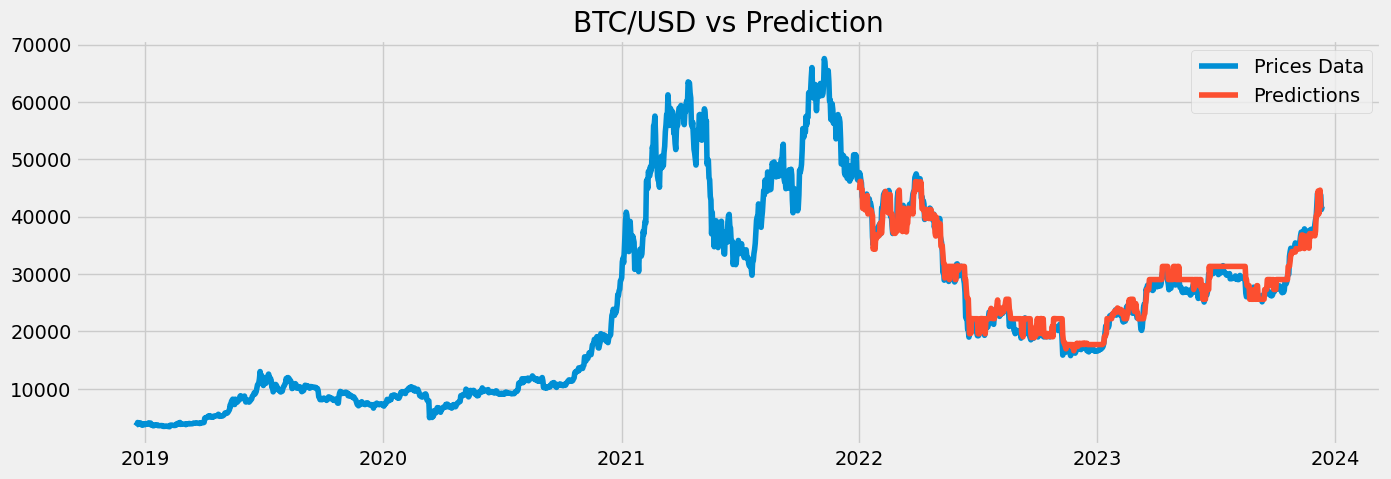

In [59]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(btc['Close'], label='Prices Data')
ax.plot(test_btc['Prediction'], label='Predictions', linestyle='-')
ax.set_title('BTC/USD vs Prediction')
ax.legend()
plt.show()

We can see that the predictions follow the movement of actual Bitcoin price.

MSE

In [60]:
mean_squared_error(test_btc['Close'], test_btc['Prediction'])

2465200.8502224013

MAPE

In [61]:
mean_absolute_percentage_error(test_btc['Close'], test_btc['Prediction'])

0.04843488408021988

# Bibliography

Vijh M., Chandola D., Tikkiwal V.A., Kumar A., 2020. Stock Closing Price Prediction using Machine Learning Techniques. Procedia Computer Science, 167, 599-606. Available at: https://doi.org/10.1016/j.procs.2020.03.326 [Accessed 10 December 2023]

Gong, J., Chu, S., Mehta, R.K., McGaughey A.J.H., 2022. XGBoost model for electrocaloric temperature change prediction in ceramics. npj Computational Materials, 8, 140. Available at: https://doi.org/10.1038/s41524-022-00826-3 [Accessed 10 December 2023]